In [249]:
# importing neccessary packages

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [250]:
# One-Hot Encoding Function
def one_hot_encode(sequence):
    """Convert DNA sequence to one-hot encoded matrix"""
    nucleotides = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    encoding = np.zeros((4, len(sequence)))
    for i, nucleotide in enumerate(sequence.upper()):
        if nucleotide in nucleotides:
            encoding[nucleotides[nucleotide], i] = 1

    # print(encoding)
    return encoding


In [ ]:
def load_dataset(file_path):
    
    # Load sequences and labels from a single file; Each line format: SEQUENCE_STRING LABEL

    sequences = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line into sequence and label
            parts = line.strip().split()
            
            # Last element is the label
            label = int(parts[-1])
            
            # Join all elements except the last one to form the sequence
            sequence = ''.join(parts[:-1])
            
            sequences.append(sequence)
            labels.append(label)
    
    # print(f"Number of sequences in the input file: {len(sequences)}")
    # print(labels)
    return sequences, labels

In [ ]:
# Custom Dataset Class
class GenomicDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32) # converting the data points into a tensor value of float 32
        self.labels = torch.tensor(labels, dtype=torch.long) # converting the labels into a tensor value of long
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx] # retrieving data samples one by one using index value

In [ ]:
# 1D CNN Alexnet Model
class AlexNet1D(nn.Module):
    def __init__(self, input_channels=4, num_classes=2, input_length=120): # ATGC, 0|1, sequence length
        super(AlexNet1D, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 96, kernel_size=11, stride=4), # input channels - 4, 96 is number of kernels or output channels, kernel size and stride
            nn.ReLU(inplace=True), # modifying the input tensor directly saving memmory
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2) # again, reduces the sequence length
        )
        
        # flattened size
        def _get_conv_output(input_shape): # helper functionto compute output size of extraction layers after convolution and pooling
            batch_size = 1
            x = torch.randn(batch_size, input_channels, input_shape) # create a dummy input tensor, here input shape is the input length=120
            x = self.features(x) # passing to convolutional layer
            return x.view(batch_size, -1).size(1) # returns the flattened size
        
        conv_output_size = _get_conv_output(input_length)
        
        self.classifier = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x) # passing through convolutional and pooling
        x = x.view(x.size(0), -1) # flattened
        x = self.classifier(x)
        return x


In [ ]:
# NiN 1D Model
class NiN1D(nn.Module):
    def __init__(self, input_channels=4, num_classes=2, input_length=120):
        super(NiN1D, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 192, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv1d(192, 160, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            
            nn.Conv1d(160, 96, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv1d(96, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Dropout(0.5)
        )
        
        # flattened size
        def _get_conv_output(input_shape):
            batch_size = 1
            x = torch.randn(batch_size, input_channels, input_shape)
            x = self.features(x)
            return x.view(batch_size, -1).size(1)
        
        conv_output_size = _get_conv_output(input_length)
        
        self.classifier = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Training 
def train_model(model, dataloader, criterion, optimizer, device, epochs=5): # parameter: -model to be trained alexnet or NiN, data and label, criterion - loss function eg nn.CrossEntropyLoss, 
    model.train() # setting the model to training mode
    train_losses = [] # storing loss
    train_accuracies = [] # storing accuracy
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad() # clears the gradient from the previous step
            outputs = model(inputs)
            loss = criterion(outputs, labels) # loss computatino
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.2f}%')
    
    return train_losses, train_accuracies


In [ ]:
# Testing 
def testing(model, test_loader, device):
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


In [ ]:

def prepare_data(file_path):
    
    # Prepare data 
    # 1. Load full dataset
    # 2. One-hot encode sequences
    # 3. Split into train and test sets
    # 4. Create DataLoaders
    
    # Load full dataset
    sequences, labels = load_dataset(file_path)
    
    # One-hot encode sequences
    encoded_data = np.array([one_hot_encode(seq) for seq in sequences])
    
    # to check the sequence
    # print(f"Sequence length: {encoded_data.shape[2]}")
    # print(f"Total sequences: {len(sequences)}")
    
    # Split data into train and test sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        encoded_data, labels, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = GenomicDataset(X_train, y_train)
    test_dataset = GenomicDataset(X_test, y_test)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

In [ ]:
# Plotting Functions
def plot_accuracies(experiments):
    """
    Plot accuracies for different experiments
    """
    plt.figure(figsize=(10, 6))
    for exp in experiments:
        plt.plot(exp['accuracies'], 
                 label=f"{exp['model_name']} (LR: {exp['hyperparams']['lr']})")
    
    plt.title('Model Accuracy across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# confusion matrix
def plot_confusion_matrices(experiments, num_classes=2):
    """
    Plot confusion matrices for different experiments
    """
    plt.figure(figsize=(15, 10))
    for i, exp in enumerate(experiments, 1):
        plt.subplot(2, 2, i)
        cm = confusion_matrix(exp['true_labels'], exp['predictions'], labels=np.arange(num_classes))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{exp['model_name']} (LR: {exp['hyperparams']['lr']})")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

    # to check the number of true labels and predictions
    # for exp in experiments:
    #     print(f"Model: {exp['model_name']}")
    #     print(f"Number of true labels: {len(exp['true_labels'])}")
    #     print(f"Number of predictions: {len(exp['predictions'])}")
    #     print(f"Unique true labels: {set(exp['true_labels'])}")
    #     print(f"Unique predictions: {set(exp['predictions'])}")

Using device: cpu
Number of sequences in the input file: 10000
Sequence length: 120
Total sequences: 10000
Epoch 1: Loss = 0.6651, Accuracy = 59.21%
Epoch 2: Loss = 0.6365, Accuracy = 64.46%
Epoch 3: Loss = 0.6172, Accuracy = 66.58%
Epoch 4: Loss = 0.5949, Accuracy = 69.22%
Epoch 5: Loss = 0.5602, Accuracy = 71.86%
Epoch 1: Loss = 0.6660, Accuracy = 58.50%
Epoch 2: Loss = 0.6354, Accuracy = 64.54%
Epoch 3: Loss = 0.6251, Accuracy = 65.71%
Epoch 4: Loss = 0.6054, Accuracy = 67.96%
Epoch 5: Loss = 0.5719, Accuracy = 70.75%
Epoch 1: Loss = 0.6798, Accuracy = 55.12%
Epoch 2: Loss = 0.6428, Accuracy = 63.52%
Epoch 3: Loss = 0.6312, Accuracy = 64.95%
Epoch 4: Loss = 0.6309, Accuracy = 65.44%
Epoch 5: Loss = 0.6313, Accuracy = 64.67%
Epoch 1: Loss = 0.6697, Accuracy = 58.00%
Epoch 2: Loss = 0.6350, Accuracy = 64.15%
Epoch 3: Loss = 0.6333, Accuracy = 64.42%
Epoch 4: Loss = 0.6256, Accuracy = 65.21%
Epoch 5: Loss = 0.6251, Accuracy = 65.69%


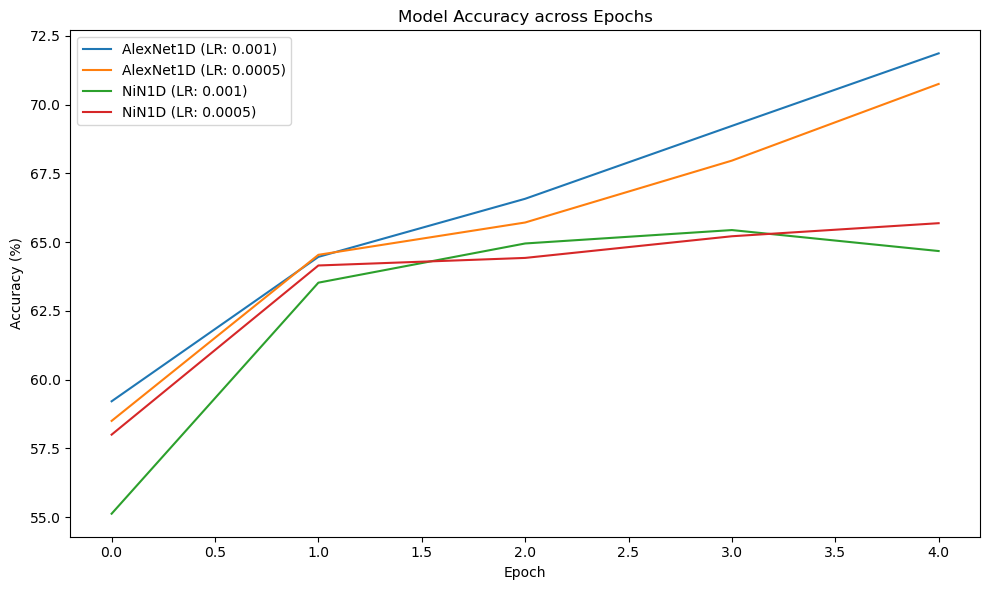

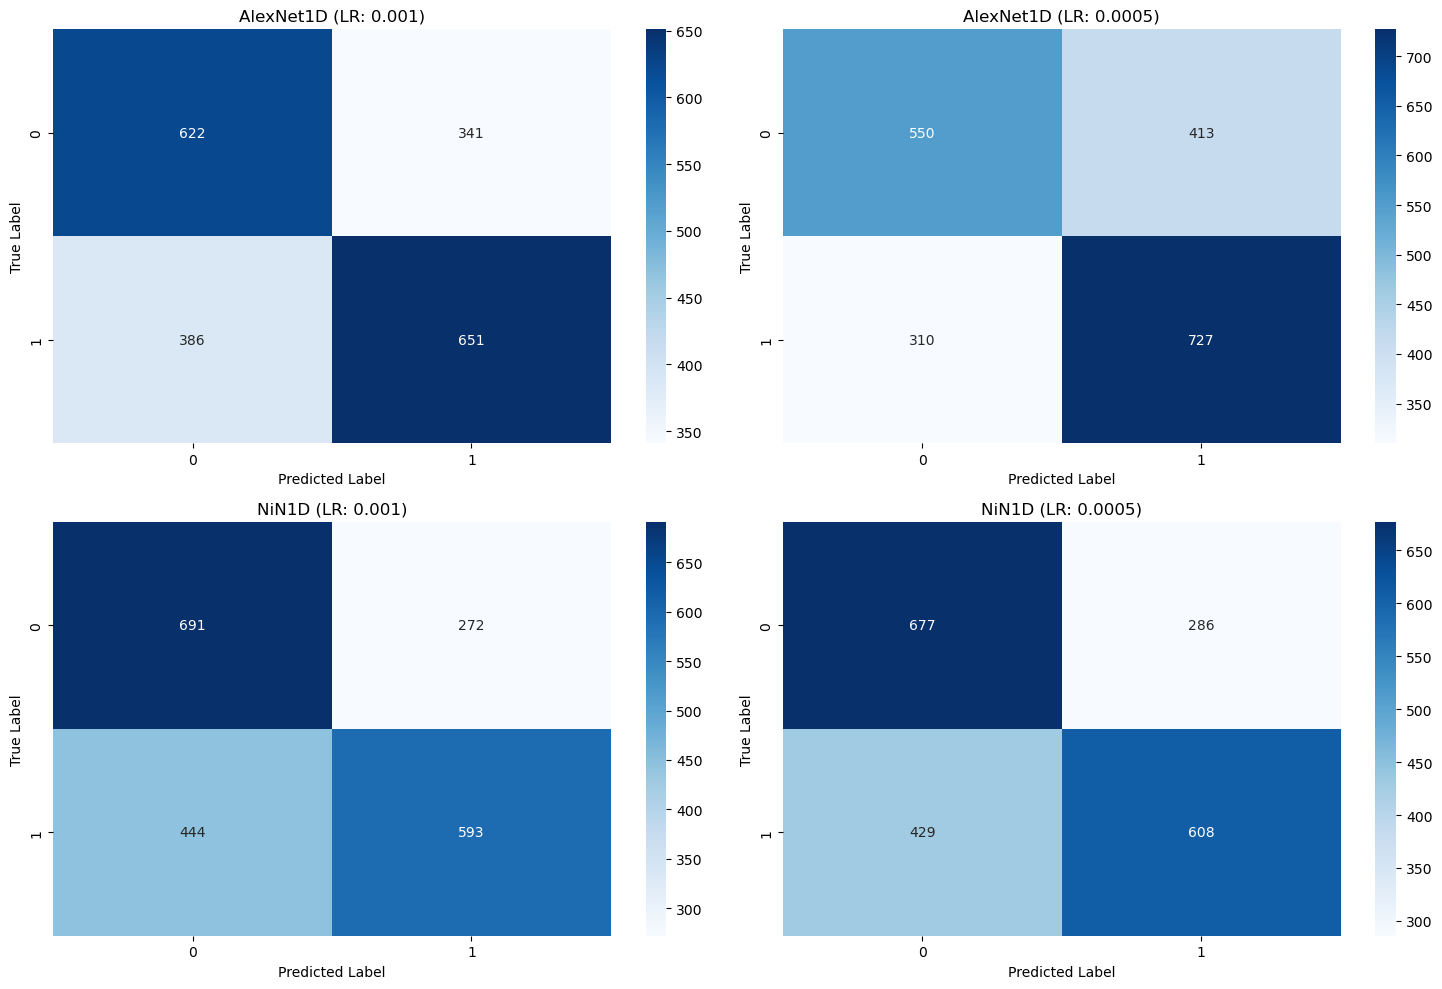

Model: AlexNet1D
Number of true labels: 2000
Number of predictions: 2000
Unique true labels: {0, 1}
Unique predictions: {0, 1}
Model: AlexNet1D
Number of true labels: 2000
Number of predictions: 2000
Unique true labels: {0, 1}
Unique predictions: {0, 1}
Model: NiN1D
Number of true labels: 2000
Number of predictions: 2000
Unique true labels: {0, 1}
Unique predictions: {0, 1}
Model: NiN1D
Number of true labels: 2000
Number of predictions: 2000
Unique true labels: {0, 1}
Unique predictions: {0, 1}


In [ ]:
# note:- enter the correct file path

def main():
    # dataset files- 1000.txt, 10000.txt, dataset.txt
    file_path = '10000.txt'  
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    train_loader, test_loader = prepare_data(file_path)
    
    # Hyperparameter configurations
    hyperparams = [
        {'lr': 0.001, 'weight_decay': 1e-5},
        {'lr': 0.0005, 'weight_decay': 5e-5}
    ]
    
    # Experiments
    experiments = []
    
    # Run experiments for Alexnet and NiN
    for model_class in [AlexNet1D, NiN1D]:
        for params in hyperparams:
            
            model = model_class(input_length=120).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), 
                                   lr=params['lr'], 
                                   weight_decay=params['weight_decay'])
            
            # Training
            losses, accuracies = train_model(
                model, train_loader, criterion, optimizer, device
            )
            
            # Testing
            test_accuracy, predictions, true_labels = testing(
                model, test_loader, device
            )
            
            experiments.append({
                'model_name': model_class.__name__,
                'hyperparams': params,
                'losses': losses,
                'accuracies': accuracies,
                'predictions': predictions,
                'true_labels': true_labels
            })
    
    # Plotting
    plot_accuracies(experiments)
    plot_confusion_matrices(experiments)

if __name__ == '__main__':
    main()